# NLP Technique exploration notebook #

This notebook is part of my journey into Machine Learning, the idea is to investigate and learn about the various different techniques of Natural Language Processing, then try to apply them to a dataset and find out what we can learn from it. The dataset I'll use consists of about 500,000 reviews of fine foods from Amazon

In [3]:
#Importing pandas which is great tool to handle data easily

import pandas as pd
#Analisis de datos
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import sklearn
from sklearn.decomposition import NMF, LatentDirichletAllocation
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from matplotlib import pyplot as plt
%matplotlib inline



#Pre-procesamiento de datos
import numpy as np
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, decomposition, model_selection, metrics
import gensim 
import scipy

# Modelos predictivos
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import keras


import tensorflow as tf

stop_words = stopwords.words('english')
py.init_notebook_mode(connected=True)

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
#First things first#

We start by analyzing the data we have, see what are the important attributes, etc

In [4]:
train= pd.read_csv("Amazon reviews/Reviews.csv")

In [5]:
train.shape

(568454, 10)

So we have 568454 reviews that have 10 features each! <br />
Let's see what the reviews look like

In [6]:
train.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

It seems like the most relevant features are: <br />
    -The text feature that contains the review itself <br />
    -The Summary of the review
    -The score the author of the review gave the product, which is a number ranging from 1 to 5 <br />
    -The feature HelpfulnessNumerator which means how many people found the review usefull <br />
    -The feature HelpfulnessDenominator which means how many people indicated whether the review was helpfull or not    

The first thing that i'm wondering is what the score value distribution looks like, so lets check that out

In [9]:
var = 0
for i in range(len(train['Text'])):
    if train['Score'][i]==1:
           var+=1
            
print(var)

52268


In [33]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [34]:
data = [go.Bar(
            x = [5,4,1,3,2],
            y = train.Score.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.Score.value_counts().values
                        ),
            text='Reviews'
    )]

layout = go.Layout(
    title='Score distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')
#py.plot(fig, filename='barplot.html')

c:\users\luciano\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



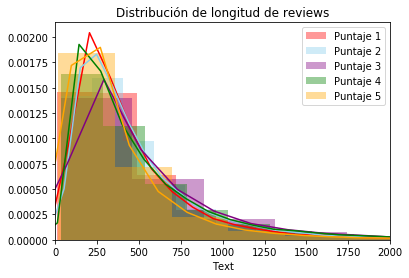

In [8]:
s1 = train[train['Score'] == 1]['Text'].str.len()
sns.distplot(s1,color="red", label='Puntaje 1')
s2 =  train[train['Score'] == 2]['Text'].str.len()
sns.distplot(s2,color="skyblue", label='Puntaje 2')
s3 = train[train['Score'] == 3]['Text'].str.len()
sns.distplot(s3,color="purple", label='Puntaje 3')
s4 = train[train['Score'] == 4]['Text'].str.len()
sns.distplot(s4,color="green" ,label='Puntaje 4')
s5 = train[train['Score'] == 5]['Text'].str.len()
sns.distplot(s5,color="orange", label='Puntaje 5')
plt.title('Distribución de longitud de reviews')
#sns.plt.ylim(0, 1000)
plt.xlim(0, 2000)
plt.legend()

In [9]:
train["Sentiment"] = train["Score"].apply(lambda score: "positive" if score > 3 else ("negative" if score <3 else "neutral"))
#Pasando a valores numericos  NEGATIVE=0 POSITIVE= 1 NEUTRAL = 2
train["SentimentB"] = train["Score"].apply(lambda score: 1 if score > 3 else (0 if score <3 else 2))

In [10]:
train['Helpful %'] = np.where(train['HelpfulnessDenominator'] > 0, train['HelpfulnessNumerator'] / train['HelpfulnessDenominator'], -1)
train.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

  Sentiment  SentimentB  Helpful %  
0  positive           1        1.0  
1  negative           0       -1.0  
2  positive           1        1.0  
3  negative           0        1.0  
4  positive           1       -1.0

In [11]:
train.rename(columns={'HelpfulnessNumerator': 'PosVotes'}, inplace=True)
train['NegVotes'] = (train['HelpfulnessDenominator']-train['PosVotes'])
train.head()

Id   ProductId          UserId                      ProfileName  PosVotes  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian         1   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa         0   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"         1   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl         3   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"         0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   
2                       1      4  1219017600  "Delight" says it all   
3                       3      2  1307923200         Cough Medicine   
4                       0      5  1350777600            Great taffy   

                                                Text Sentiment  SentimentB  \
0  I have bought several of the Vitality canned d...  positive           1   
1  Product arrived labeled as Jumbo Salted Peanut...  negative           0   
2  This is a confection that has been around a fe...  positive           1   
3  If you are looking for the secret ingredient i...  negative           0   
4  Great taffy at a great price.  There was a wid...  positive           1   

   Helpful %  NegVotes  
0        1.0         0  
1       -1.0         0  
2        1.0         0  
3        1.0         0  
4       -1.0         0

### WORDCLOUDS
Wordclouds are a great way to quickly see what the general sentiment of the reviews are.

In [13]:
# We make all words lowercase, then separate each word in the reviews
import re
import string
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    if type(sentence) is str:
        sentence = sentence.lower()
        sentence = cleanup_re.sub(' ', sentence).strip()
    return sentence

train["Summary_Clean"] = train["Summary"].apply(cleanup)

In [14]:
# Let's take the reviews with the highest scores and the ones with the lowest
star1= train[train.Score==1]["Summary_Clean"].values
star5= train[train.Score==5]["Summary_Clean"].values


In [15]:
#We can use pictures as an outline for the wordcloud
import codecs
from PIL import Image
img = Image.open("Masks/hamburger2.jpg")
hcmask = np.array(img)
img = Image.open("Masks/apple2.jpg")
hcmask2= np.array(img)

(-0.5, 1299.5, 856.5, -0.5)

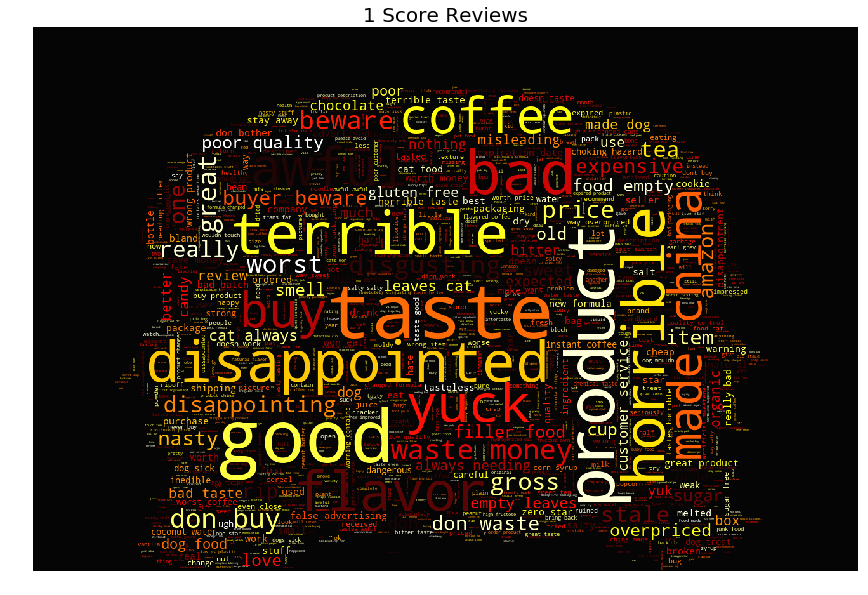

In [16]:
# Here we generate the 1 score wordcloud
plt.figure(figsize=[20,10])
wc=WordCloud(width=1200, height=600,background_color='black',mask=hcmask,max_words=2000,stopwords=STOPWORDS,max_font_size=120)
wc.generate(" ".join(str(v) for v in star1))
plt.title("1 Score Reviews", fontsize=20)
plt.imshow(wc.recolor(colormap='hot',random_state=17), alpha=0.98)
plt.axis('off')
#savefig('bad_food_wordcloud.png', bbox_inches='tight')

(-0.5, 599.5, 517.5, -0.5)

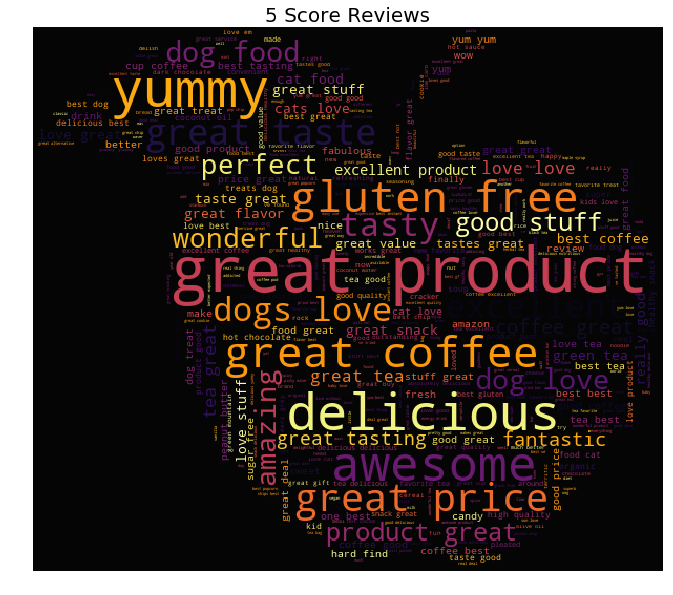

In [17]:
# Here the 5 score wordcloud
plt.figure(figsize=[20,10])
wc=WordCloud(width=1200, height=600, background_color='black',mask=hcmask2,max_words=2000,stopwords=STOPWORDS,max_font_size=80)
wc.generate(" ".join(str(v) for v in star5))
plt.title("5 Score Reviews", fontsize=20)
plt.imshow(wc.recolor(colormap='inferno',random_state=17), alpha=0.98)
plt.axis('off')


## Latent Dirichlet Allocation 
Latent dirichlet allocation is a stadistic model, that uses unsupervised learning to form clusters of samples that are related to each other. In the context of NLP, this technique will make groups of related words that we will call topics, and that then means that each review is formed by a distribution of topics. <br />
An example: <br />
We could have <br />
topic 1: tasty good delicious, amazing, great <br />
topic 2: sugar, candy, tasty, dessert <br />
So then we could have a review that is 40% topic 1 and 60% topic B <br />
This can be useful to determine which reviews are similar to each other without having to read them all <br /> 
As this is unsupervised learning, we are the ones that have to decide what the meaning of the topics are, the model will just give us topic 1, 2, 3 etc. 


In [18]:
#I took 3000 samples of the reviews with score 1 and 3000 of reviews with score 5
#Then I made a matrix formed by the bag of words vector of each review
star1_text= train[train.Score==1]["Text"].values
star5_text= train[train.Score==5]["Text"].values
star1_text_sample= star1_text[:3000].copy()
star5_text_sample= star5_text[:3000].copy()

countvec_lda= LemmaCountVectorizer(max_df=0.95,min_df=5,stop_words="english",decode_error='ignore')
X_train_counts_lda_neg = countvec_lda.fit_transform(star1_text_sample)   # Matriz bag of words de los datos de entrenamiento

print(X_train_counts_lda_neg.shape)
print(X_train_counts_lda_neg.toarray())

(3000, 2775)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


This means we have 3000 reviews, and we have 2775 unique words. The vectors wil have a 1  if the word appears in the review and a 0 if it doesn't

In [19]:
#I instantiate the LDA model and train it, I decided to generate 14 topics
lda = LatentDirichletAllocation(n_components=14,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0,
                                n_jobs=-1)
lda_Z= lda.fit_transform(X_train_counts_lda_neg)

print(lda_Z.shape,"\n")


(3000, 14) 



In [20]:
# The topics are composed by words, with each word having a different weight, so let's see the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = countvec_lda.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:chip bag potato kettle sour seasoning cream rancid chick opened case brand bug grease just 2013 clam retriever golden onion mustard worm unhappy enjoy gone hated gross favorite soon awful smelled like chowder texture larva br stain snack crawling cheddar

Topic #1:br juice organic mix syrup soup jar drink bread fruit best switch earth apple pumpkin 100 fructose orange pancake soda berry tomato blueberry dha cherry added canned taste vitamin flavor pizza doe ounce certified calorie litter kiwi bpa grape use

Topic #2:flavor spicy chip onion popchips yuck version nasty jalapeno like thai lay instead expectation crisp hershey rock ranch taste baked new texture oily kettle changed spiced character dressing cutting cocktail honest asian bunch better star great tossed us zero trying

Topic #3:box cooky broken cracker jerky piece date 00 arrived expiration candy crumb meat strip tasty received ordered cookie garlic bubble vegetarian order filled soy beef seal 

### We can use wordclouds again to see what the topics look like

In [21]:
first_topic_neg = lda.components_[3]
second_topic_neg = lda.components_[8]
#third_topic_neg = lda.components_[2]
#fourth_topic = lda.components_[3]

In [22]:
from wordcloud import WordCloud, STOPWORDS
first_topic_words_neg = [tf_feature_names[i] for i in first_topic_neg.argsort()[:-50 - 1 :-1]]
second_topic_words_neg = [tf_feature_names[i] for i in second_topic_neg.argsort()[:-50 - 1 :-1]]
#third_topic_words_neg = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
#fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

In [23]:
# Generating the wordcloud
def wordcloud_lda(topic_words):
    cloud = WordCloud(   stopwords=STOPWORDS,
                          background_color='black',
                          width=3500,
                          max_font_size=750,
                          height=2400,
                         ).generate(" ".join(topic_words))
    plt.figure(figsize=[11,5.5])
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

In [24]:
X_train_counts_lda_pos = countvec_lda.fit_transform(star5_text_sample)
lda_Z= lda.fit_transform(X_train_counts_lda_pos)
tf_feature_names = countvec_lda.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topic #0:sauce bottle br hot juice salad chicken tomato use egg heat dish mustard soy add vegetable love dressing fish flavour chili sweet just calcium burn curry stir supplement home rice marinade spot child asian lemon dove san unique white allergy

Topic #1:mic icicle sound beverage usb audio blue recording record driver plug window pc mac device condenser gain knob solution voice microphone studio unit professional sample sensitivity adjust britt forget create flat filter silver literally figure soaked short orange ultimate costa

Topic #2:br good like great flavor taste chip just love product really best time don buy try bag ve tried make little chocolate price box delicious snack calorie eat favorite better brand amazon thing use salt recommend pack say way potato

Topic #3:kavli em rough lollipop inch receive sooooo promptly ate bad fast wrap munch contacted recording 1st service 16 br sauce seller bubble use gain party really just agree hot audio thank don taste expected good 

In [25]:
first_topic_pos = lda.components_[1]
second_topic_pos = lda.components_[12]
#third_topic_pos = lda.components_[2]

In [26]:
from wordcloud import WordCloud, STOPWORDS
first_topic_words_pos = [tf_feature_names[i] for i in first_topic_pos.argsort()[:-50 - 1 :-1]]
second_topic_words_pos = [tf_feature_names[i] for i in second_topic_pos.argsort()[:-50 - 1 :-1]]
#third_topic_words_neg = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
#fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

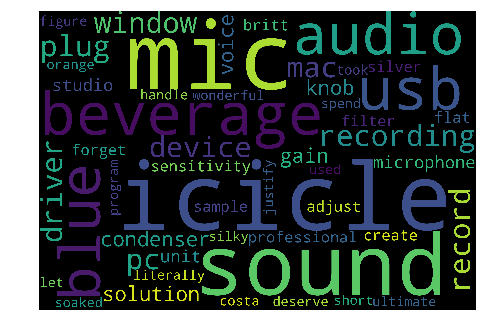

In [27]:
wordcloud_lda(first_topic_words_pos)

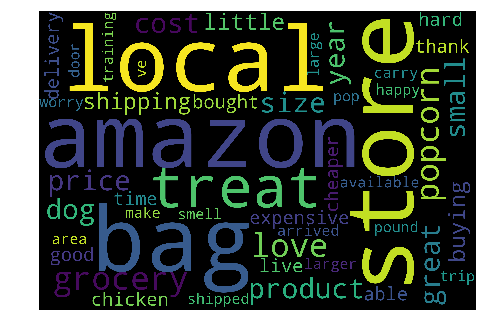

In [28]:
wordcloud_lda(second_topic_words_pos)

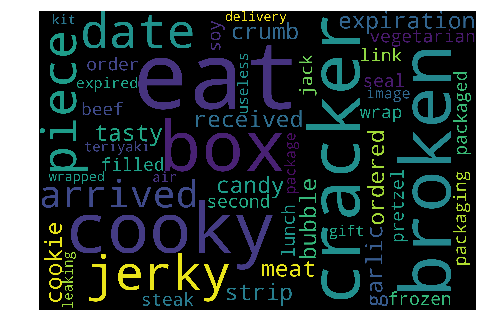

In [29]:
wordcloud_lda(first_topic_words_neg)

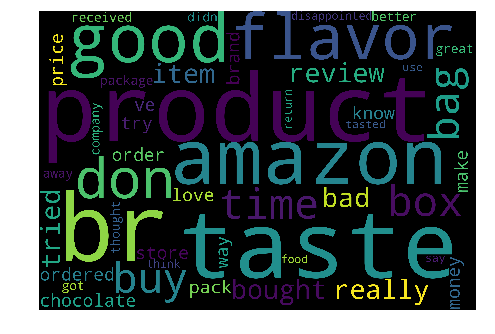

In [30]:
wordcloud_lda(second_topic_words_neg)

# Text pre-processing

In [31]:
#Contractions
# found at http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [32]:
#Replacing irrelevant characters

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"br", " ")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"href", "")
    df[text_field] = df[text_field].str.lower()
    # Reemplazo contractions
    dflist=df[text_field].tolist()
    for i in range(len(dflist)):
        if True:
            dflist[i] = dflist[i].split()
            new_text = []
            for word in dflist[i]:
                if word in contractions:
                    new_text.append(contractions[word])
                else:
                    new_text.append(word)
            dflist[i] = " ".join(new_text)
            
    
    return dflist

train_list = standardize_text(train, "Text")

train.to_csv("clean_data.csv")

In [35]:
print("Here's an example of a clean review")
print(train_list[20])

Here's an example of a clean review


NameError: name 'train_list' is not defined

In [34]:
train= pd.read_csv("clean_data.csv")

# BALANCED DATA

In [35]:
#texto=train.Text.tolist() # This will be X
texto= train_list
scores=train.SentimentB.tolist() # This will be  Y
print(texto[:2])


['i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my la ador is finicky and she appreciates this product better than most', 'product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as "jumbo"']


In [36]:
#I found this function that allows you to select from the dataset a certain amount of reviews with each score
#In this case I decided to take 30.000 reviews for every sentiment value, meaning 90.000 reviews total
def balanced_sample_maker(X, y, sample_size, random_seed=None):
    """ return a balanced data set by sampling all classes with sample_size 
        current version is developed on assumption that the positive
        class is the minority.

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)
    return (balanced_copy_idx)

index_b = balanced_sample_maker(texto,scores, int((30000)))

In [37]:
print(len(index_b))

90000


In [38]:
xbalanced= []
ybalanced= []
for i in range(len(index_b)):
    xbalanced.append(texto[index_b[i]])
    ybalanced.append(scores[index_b[i]])

In [39]:
print(ybalanced.count(0))
print(ybalanced.count(1))
print(ybalanced.count(2))

30000
30000
30000


In [40]:
print(len(xbalanced))

90000


Para entrenar el modelo y testear las predicciones, divido los datos en conjunto de entrenamiento y conjunto de test

In [41]:
#Splitting data into training and validation sets
# Stratify is used so the training  and testing sets have the same proportion of sentiment values as the original set
#This means if there are 50% positive reviews, 20% negative and  y 30% neutral, The same proportion will exist in the 
#training and validation set
#Random state is the seed for the random number generator, it allows you to replicate results if needed
X_train, X_test, y_train, y_test = train_test_split(xbalanced, ybalanced,stratify=ybalanced, test_size=0.2, random_state=40)

In [42]:
print(len(X_train))
print(len(X_test))

72000
18000


# Reviews Vectorization

In [43]:
#Instanciating Count Vectorizer
countvec= LemmaCountVectorizer(max_df=0.95,min_df=5,stop_words="english",decode_error='ignore') #agregar ngram?


In [44]:
#Converting review's list into bag of words
X_train_counts = countvec.fit_transform(X_train)   # Matriz bag of words de los datos de entrenamiento
X_test_counts = countvec.transform(X_test)         # Matriz bag of words de datos de testeo

print("Shape de la matriz BOW:",X_train_counts.shape)

Shape de la matriz BOW: (72000, 14745)


In [45]:
# Principal Component Analisis Graph
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=3)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','green']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Negative')
            green_patch = mpatches.Patch(color='blue', label='Positive')
            blue_patch = mpatches.Patch(color='green',label="Neutral")
            plt.legend(handles=[red_patch, green_patch,blue_patch], prop={'size': 30})


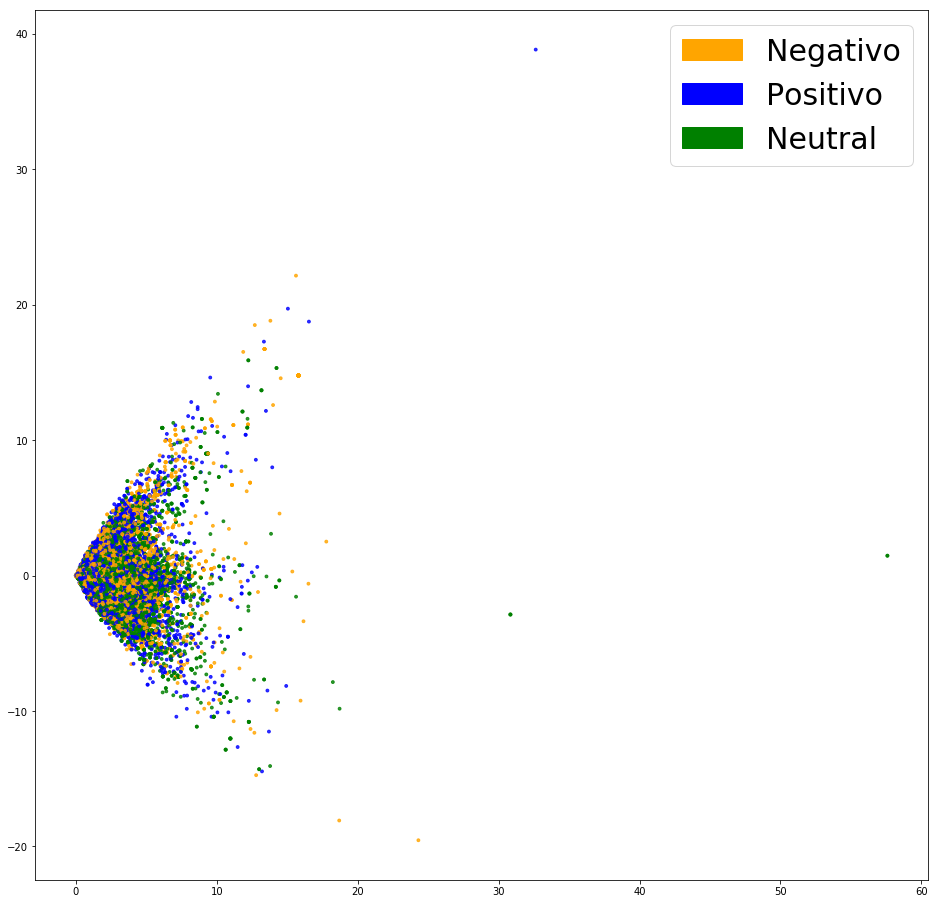

In [46]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

Looking at this graph, it doesn't seem like it would be easy to differentiate between the diferent types of reviews

# Sentiment classification

In [47]:
#We can start with a simple logistic regression model
from sklearn.linear_model import LogisticRegressionCV
regstrength=[]
for i in range(10):
    regstrength.append(30.0)
clf = LogisticRegressionCV(Cs=regstrength, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

clf.fit(X_train_counts, y_train)  #I train the model with the bag of words vector of each review and their scores

y_predicted_counts = clf.predict(X_test_counts)

In [37]:
# Metrics

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1



ImportError: DLL load failed: The specified module could not be found.

In [49]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.740, precision = 0.742, recall = 0.740, f1 = 0.741


### Let's make a confusion matrix so we can see in which cases the model is making wrong predictions

In [50]:
#Confusion matrix


import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

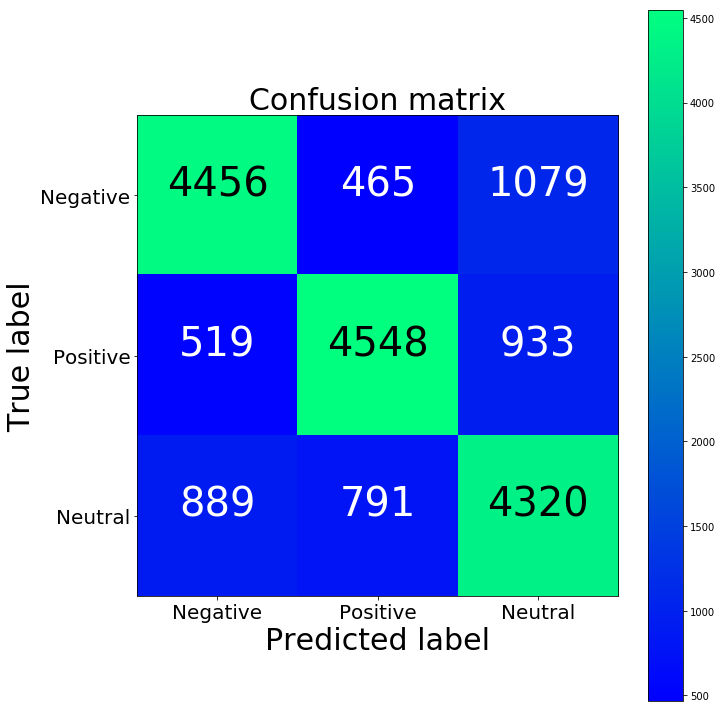

[[4456  465 1079]
 [ 519 4548  933]
 [ 889  791 4320]]


In [51]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive','Neutral'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

As we could have expected, the model seems to have an easier time differentiating between positive and negative reviews, but has a harder time with neutral reviews

We can check how the model does with the training set. This could be useful to tell if we are overfitting, in which case the metrics would be way higher than for the validating set

In [52]:
y_predicted_counts_train = clf.predict(X_train_counts)

In [36]:
accuracy, precision, recall, f1 = get_metrics(y_train, y_predicted_counts_train)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

NameError: name 'get_metrics' is not defined

# TF-IDF

In [54]:
#Lematization

lemm = WordNetLemmatizer()
class LemmaTFidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaTFidfVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [55]:
#instancio el vectorizador TF-IDF
tfidfvec= LemmaTFidfVectorizer(max_df=0.95,min_df=5, stop_words='english',decode_error='ignore',strip_accents='unicode')

In [56]:
#Convierto la lista de reviews en Bag of words
X_train_tfidf = tfidfvec.fit_transform(X_train)   # Matriz bag of words de los datos de entrenamiento
X_test_tfidf = tfidfvec.transform(X_test)         # Matriz bag of words de datos de testeo

print("Shape de la matriz BOW:",X_train_tfidf.shape)

Shape de la matriz BOW: (72000, 14745)


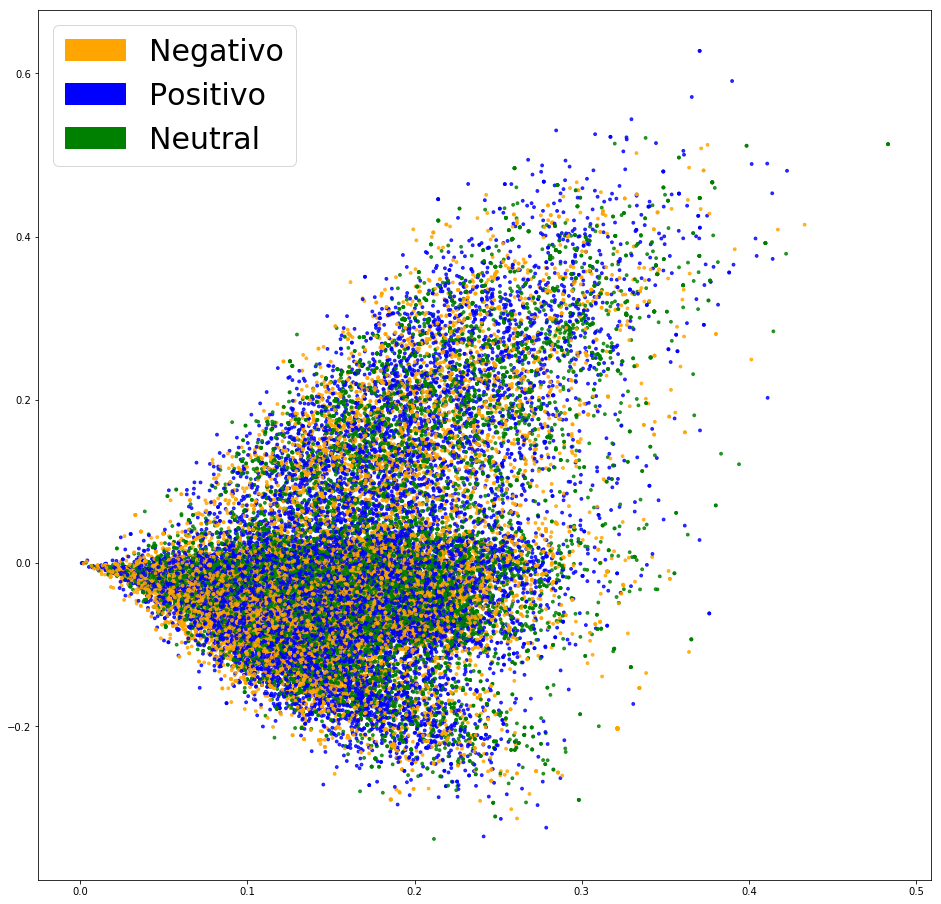

In [57]:
#Principal Component Analisis graph

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

That didn't seem to help much

 ### vectorizer coefficient's:

**It indicates the degree of influence that each word has in the model's prediction**

In [58]:
 words = tfidfvec.get_feature_names()
 feature_coefs = pd.DataFrame(
     data = list(zip(words, clf.coef_[1])),
     columns = ['feature', 'coef'])

 feature_coefs.sort_values(by='coef')

feature       coef
7593       likewise  -9.979263
3459       darkness  -9.958982
4151     downgraded  -8.253997
603     adulterated  -8.221139
9959          prawn  -7.874527
7064         jammed  -7.846313
11925      smashing  -7.818748
12524  straightened  -7.332176
2210      carnitine  -7.293392
1305     babysitter  -7.078788
99            180mg  -7.034846
625         advisor  -6.889319
10645        regain  -6.884699
13594        tuning  -6.842567
2161     carageenan  -6.794994
8308         mishap  -6.712353
9440        peanuty  -6.681672
4510         emptor  -6.672817
256              3d  -6.543234
7052         jagged  -6.490451
13293        tipped  -6.414593
9407         patted  -6.407796
11941    smithfield  -6.362572
13465    transplant  -6.357779
5465          frost  -6.318715
12641       subside  -6.305901
12287       spotted  -6.302825
13851  unremarkable  -6.281326
13775      unharmed  -6.265011
4726           evil  -6.235785
...             ...        ...
11532        server   5.992587
2032       bzzagent   6.004692
9891      possessed   6.008145
1275    awesomeness   6.012226
6550       ignorant   6.016009
4821       expeller   6.056632
13684    unbeatable   6.077591
9755        pleaser   6.122422
5154         fitted   6.156056
10730        remake   6.198884
5017         feared   6.245728
10711      reliably   6.404588
14390       westies   6.409809
8691     newsletter   6.427489
12209      speedier   6.447197
9682          piper   6.519993
2213    carnivorous   6.583492
2179     carbonator   6.669340
8755           nook   6.761359
11555           sex   6.842051
12722       summery   6.853828
9985        prefect   7.196407
1756         boggle   7.880316
13466  transplanted   7.920291
5580       gargling   8.153335
8870             nw   8.310682
4506         employ   8.391067
14386    wesselmann   8.615967
811     alternating   8.646898
11193         sadie  11.855189

[14745 rows x 2 columns]

### Logistic Regression with TF-IDF

In [59]:
clf2 = LogisticRegressionCV(Cs=regstrength, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

clf2.fit(X_train_tfidf, y_train)  #Entreno el modelo con el bag of words de cada review y los puntajes

y_predicted_tfidf = clf2.predict(X_test_tfidf)

In [60]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.744, precision = 0.745, recall = 0.744, f1 = 0.744


### Vectorizer's coefficients:

In [61]:
# words = tfidfvec.get_feature_names()
# feature_coefs = pd.DataFrame(
#     data = list(zip(words, clf2.coef_[1])),
#     columns = ['feature', 'coef'])

# feature_coefs.sort_values(by='coef')

### XGBOOST

In [62]:
# xgboost with count vectorizer

xgb_clf = xgb.XGBClassifier(objective="multi:softprob", eta=0.1,max_depth=20, n_estimators=150, colsample_bytree=0.4,colsample_bylevel=1, 
                        subsample=0.6, nthread=10,reg_lambda=10, learning_rate=0.2,min_child_weight=10,gamma=0,n_jobs=4)
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train, feature_names=tfidfvec.get_feature_names())
xgb_clf.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, eta=0.1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=20, min_child_weight=10, missing=None,
       n_estimators=150, n_jobs=4, nthread=10, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [63]:
y_predicted_xgb = xgb_clf.predict(X_test_tfidf)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


accuracy = 0.758, precision = 0.758, recall = 0.758, f1 = 0.758


c:\users\luciano\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Let's check here which words influenced the model the most when making a prediction

Text(0,0.5,'Feature Importance Score')

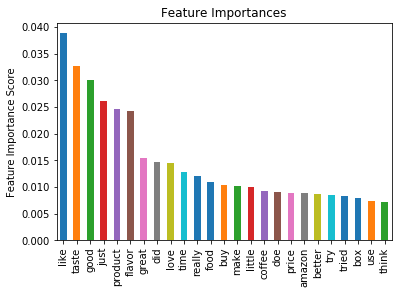

In [64]:
feat_imp = pd.Series(xgb_clf.feature_importances_, tfidfvec.get_feature_names()).sort_values(ascending=False).nlargest(25)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

That makes a lot more sense

In [65]:
import os
os.environ["PATH"] += (os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin/")

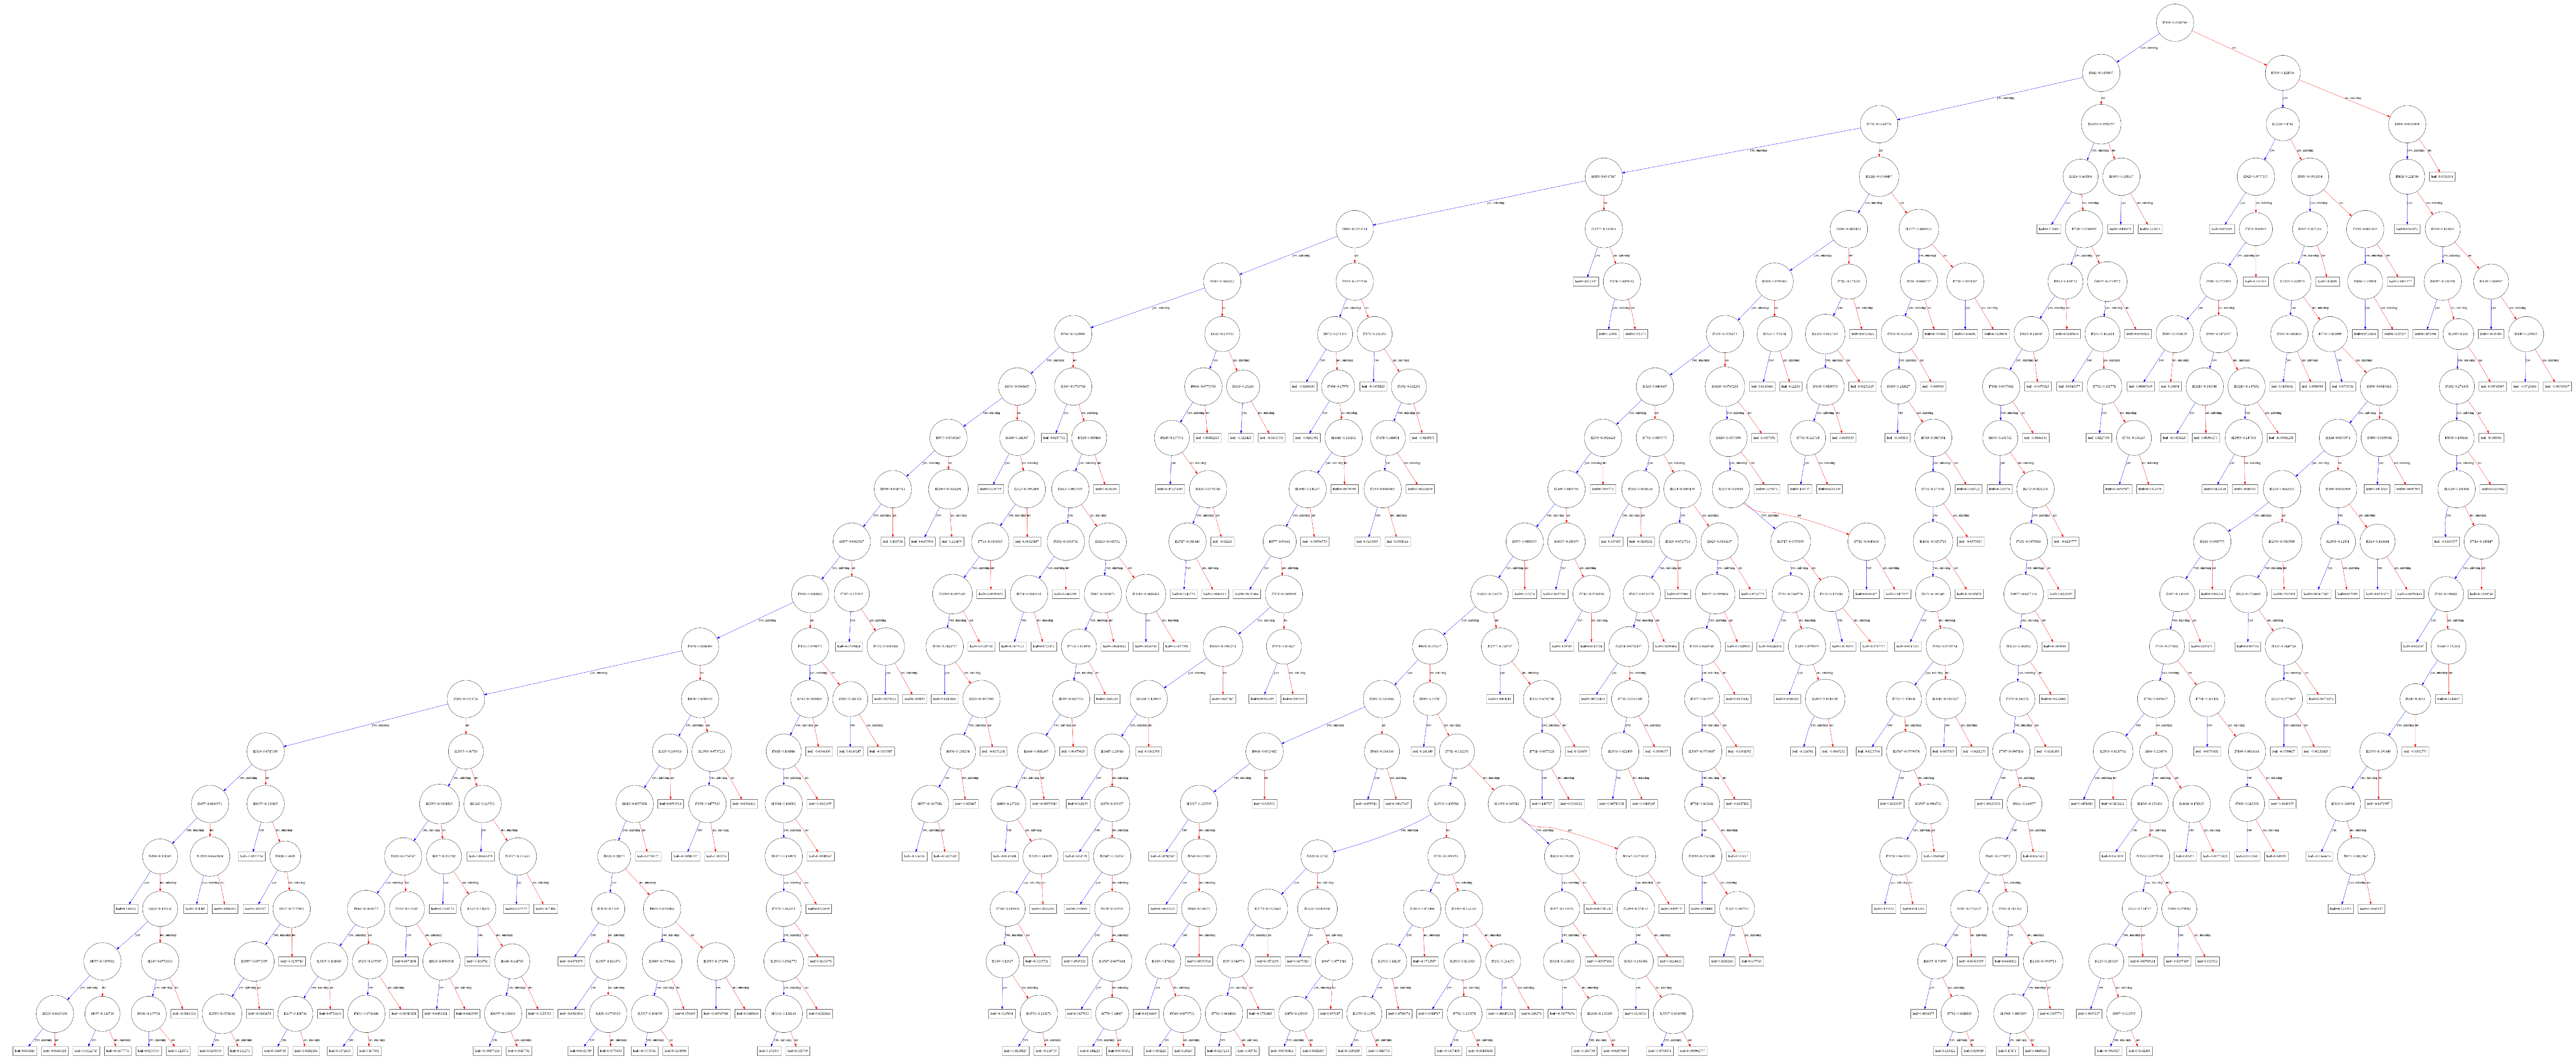

In [66]:
#We can check the XGBoost tree
xgb.plot_tree(xgb_clf, num_trees=3)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

# Word2vec
Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

After testing, it seems like the word2vec model works better if we don't eliminate stopwords, so I left them in the text

In [67]:
# train= pd.read_csv("Amazon reviews/Reviews.csv") 
# texto_noSW=train.Text.tolist()
# index_b_noSW = balanced_sample_maker(texto_noSW,puntajes, int((0.05*len(texto_noSW))))
# xbalanced_noSW= []
# ybalanced_noSW= []
# for i in range(len(index_b_noSW)):
#     xbalanced_noSW.append(texto[index_b_noSW[i]])
#     ybalanced_noSW.append(puntajes[index_b_noSW[i]])

In [68]:
print(len(ybalanced))

90000


First we tokenize the reviews, meaning we split the reviews into lists of words

In [69]:
texto_w2v=[]
print("Reviews matrix"xbalanced[:1])
for i in range(len(xbalanced)):
    texto_w2v.append(gensim.utils.simple_preprocess(xbalanced[i]))
print("Tokenized sentence matrix:",texto_w2v[:2])




['this is absolutely the worst condensed soup i have ever tasted! i used it to make another recipe, and as soon as i opened the box, i was disgusted by the smell i thought perhaps the "sell by" date had passed, but it had not i should have just thrown it away and tried to salvage my recipe some other way, but with gf ingredients, these are expensive "experiements"! my recipe tasted awful, my whole kitchen smelled like this soup, and i cannot get the taste out of my mouth this product is horrible i cannot believe it actually made it past their quality assurance dept and onto the store shelves if it was possible to give it negative stars, i would!!!!']
Matriz tokenizada de frases: [['this', 'is', 'absolutely', 'the', 'worst', 'condensed', 'soup', 'have', 'ever', 'tasted', 'used', 'it', 'to', 'make', 'another', 'recipe', 'and', 'as', 'soon', 'as', 'opened', 'the', 'box', 'was', 'disgusted', 'by', 'the', 'smell', 'thought', 'perhaps', 'the', 'sell', 'by', 'date', 'had', 'passed', 'but', 'i

In [70]:
print(len(xbalanced))
print(len(texto_w2v))

90000
90000


In [71]:
# I generate the vocabulary and train the model
#Relevant parameters for the word2vec model:
# Size it corresponds to the size or dimensionality of the feature vector
# Window: The size of the context window, how many words ahead and backwards the model takes into account
#min_count: words that have a frecuency that is less than this value will be ignored
modelo = gensim.models.Word2Vec(
        texto_w2v,
        sg=1,
        size=150,
        window=5,
        min_count=1,
        workers=4,
         hs=1,
        negative=10)

Let's check what relations our model learned with our dataset

In [72]:
print(modelo.wv.most_similar('tasty', topn=3))
print(modelo.wv.most_similar('terrible', topn=3))
print(modelo.wv.most_similar('love', topn=3))
print(modelo.wv.most_similar('food', topn=3))
print(modelo.wv.most_similar('taste', topn=3))
print(modelo.wv.most_similar('garbage', topn=3))


[('delicious', 0.8167970180511475), ('flavorful', 0.7128711342811584), ('satisfying', 0.6909090280532837)]
[('horrible', 0.8549178838729858), ('awful', 0.7453262209892273), ('bad', 0.7005589604377747)]
[('loved', 0.688713788986206), ('slushes', 0.6737226247787476), ('enjoy', 0.6724764704704285)]
[('foods', 0.7035679817199707), ('canidine', 0.6761447191238403), ('kd', 0.6372113227844238)]
[('flavor', 0.8053958415985107), ('tastes', 0.7308334708213806), ('tasting', 0.7242916822433472)]
[('trash', 0.6036971807479858), ('yor', 0.5644291639328003), ('pitching', 0.5519918203353882)]


That's pretty cool! Next I will use this word vectors to make reviews vectors, and use them to train some models

In [73]:
word_vectors= modelo.wv.vectors
word_vectors.shape

(46510, 150)

We have 46510 unique words, each one represented by a 150 dimension vector

In [74]:
# I use the average of the word vectors in a review to represent it
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 10000th review
        if counter%10000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [75]:
trainDataVecs= getAvgFeatureVecs(texto_w2v,modelo,150)

Review 0 of 90000


c:\users\luciano\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



Review 1000 of 90000
Review 2000 of 90000
Review 3000 of 90000
Review 4000 of 90000
Review 5000 of 90000
Review 6000 of 90000
Review 7000 of 90000
Review 8000 of 90000
Review 9000 of 90000
Review 10000 of 90000
Review 11000 of 90000
Review 12000 of 90000
Review 13000 of 90000
Review 14000 of 90000
Review 15000 of 90000
Review 16000 of 90000
Review 17000 of 90000
Review 18000 of 90000
Review 19000 of 90000
Review 20000 of 90000
Review 21000 of 90000
Review 22000 of 90000
Review 23000 of 90000
Review 24000 of 90000
Review 25000 of 90000
Review 26000 of 90000
Review 27000 of 90000
Review 28000 of 90000
Review 29000 of 90000
Review 30000 of 90000
Review 31000 of 90000
Review 32000 of 90000
Review 33000 of 90000
Review 34000 of 90000
Review 35000 of 90000
Review 36000 of 90000
Review 37000 of 90000
Review 38000 of 90000
Review 39000 of 90000
Review 40000 of 90000
Review 41000 of 90000
Review 42000 of 90000
Review 43000 of 90000
Review 44000 of 90000
Review 45000 of 90000
Review 46000 of 900

In [76]:
trainDataVecs2= np.array(trainDataVecs)

In [77]:
trainDataVecs2.shape

(90000, 150)

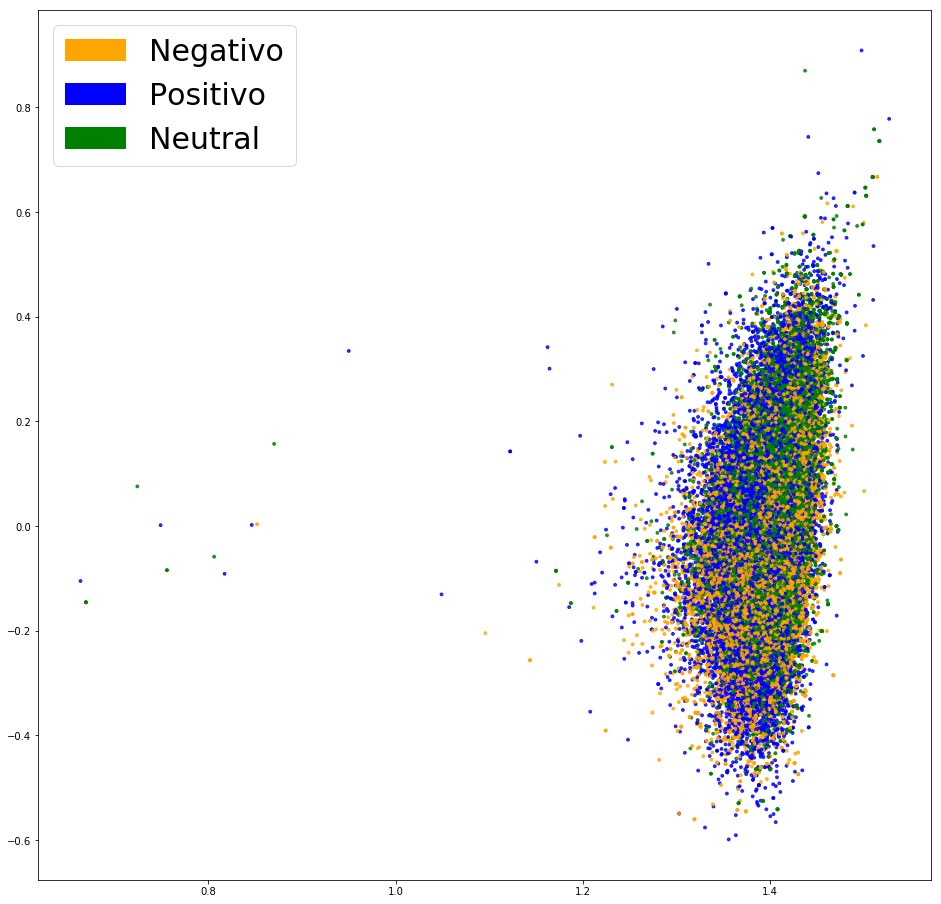

In [78]:
#Principal Component Analisis graph

fig = plt.figure(figsize=(16, 16))          
plot_LSA(trainDataVecs, ybalanced)
plt.show()

In this graph we can see the difference between the classes a lot more

In [79]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(trainDataVecs, ybalanced,stratify=ybalanced, test_size=0.2, random_state=40)

In [80]:
clf2.fit(X_train_w2v, y_train_w2v)

LogisticRegressionCV(Cs=[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0],
           class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=-1, penalty='l2',
           random_state=40, refit=True, scoring=None, solver='newton-cg',
           tol=0.0001, verbose=0)

In [81]:
y_predicted_clf_w2v= clf2.predict(X_test_w2v)
accuracy, precision, recall, f1 = get_metrics(y_test_w2v, y_predicted_clf_w2v)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


accuracy = 0.674, precision = 0.675, recall = 0.674, f1 = 0.674


Seems like the logistic regression model did worse, that's interesting

In [82]:
xgb_clf.fit(X_train_w2v, y_train_w2v)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, eta=0.1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=20, min_child_weight=10, missing=None,
       n_estimators=150, n_jobs=4, nthread=10, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [83]:
y_predicted_xgb_w2v= xgb_clf.predict(X_test_w2v)
accuracy, precision, recall, f1 = get_metrics(y_test_w2v, y_predicted_xgb_w2v)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


accuracy = 0.818, precision = 0.818, recall = 0.818, f1 = 0.818


c:\users\luciano\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Big improvement with this model!

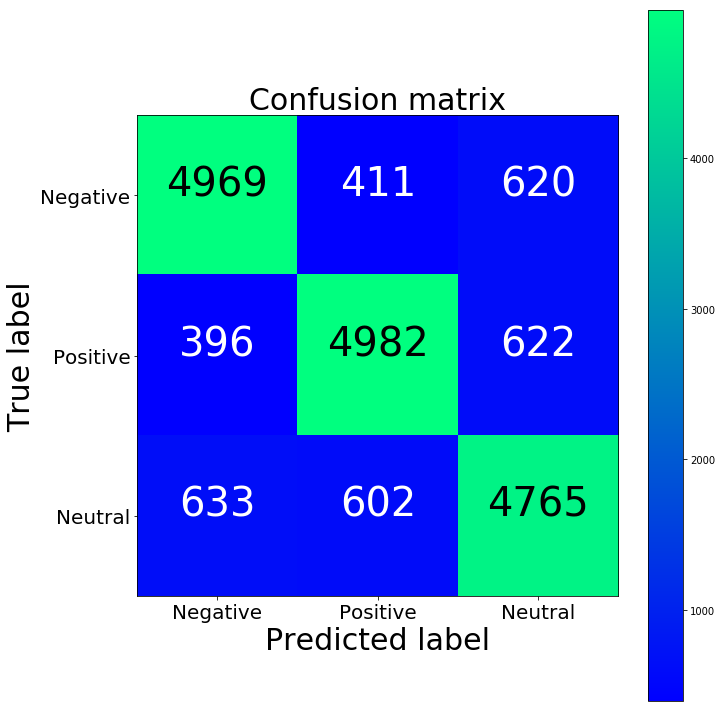

[[4969  411  620]
 [ 396 4982  622]
 [ 633  602 4765]]


In [84]:
cm = confusion_matrix(y_test, y_predicted_xgb_w2v)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive','Neutral'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

## Combining Word2Vec y LDA

Word2vec generates word embeddings, which we used to generate review embeddings. At the same time, LDA generates review embeddings, corresponding to their topic distribution, so we can try combining this embeddings and check if that turns into a better representation of the documents

In [85]:
#Instanciating LDA
lda = LatentDirichletAllocation(n_components=12,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0,
                                n_jobs=-1)


In [86]:
countvec_lda2= LemmaCountVectorizer(max_df=0.95,min_df=5,stop_words="english",decode_error='ignore') #agregar ngram?

In [87]:
# vectorizers
vec_bow= countvec_lda2.fit_transform(xbalanced)
vec_lda= lda.fit_transform(vec_bow)
print(vec_lda.shape)

(90000, 12)


In [ ]:
# topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
#     topic_importances = np.array(topic_importances)
#     return topic_importances[:,1]

# train_data['lda_features'] = list(map(lambda doc:
#                                       document_to_lda_features(LDAmodel, doc),
#                                       train_data.bow))

In [89]:
X_lda = np.array(list(map(np.array, vec_lda)))
X_w2v = np.array(list(map(np.array, trainDataVecs)))
X_combined = np.append(X_lda, X_w2v, axis=1)

In [90]:
print(X_lda.shape)
print(X_w2v.shape)


(90000, 12)
(90000, 150)


In [91]:
print(X_combined.shape)
print(len(ybalanced))


(90000, 162)
90000


In [92]:
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, ybalanced,stratify=ybalanced, test_size=0.2, random_state=40)

In [93]:
xgb_clf.fit(X_train_combined, y_train_combined)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, eta=0.1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=20, min_child_weight=10, missing=None,
       n_estimators=150, n_jobs=4, nthread=10, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [94]:
y_predicted_xgb_combined= xgb_clf.predict(X_test_combined)
accuracy, precision, recall, f1 = get_metrics(y_test_w2v, y_predicted_xgb_combined)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


c:\users\luciano\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



accuracy = 0.819, precision = 0.819, recall = 0.819, f1 = 0.819


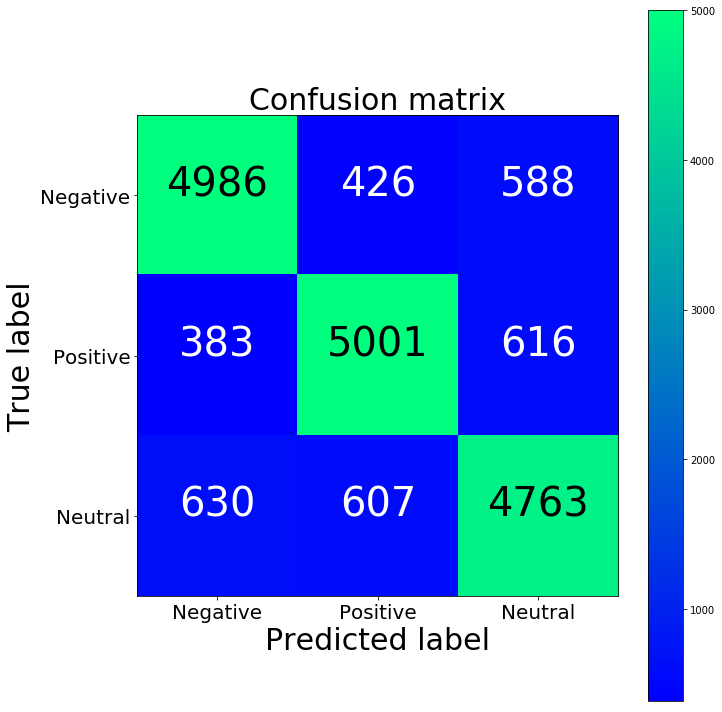

[[4986  426  588]
 [ 383 5001  616]
 [ 630  607 4763]]


In [95]:
cm = confusion_matrix(y_test, y_predicted_xgb_combined)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive','Neutral'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

That didn't seem to do much

# LSTM

In [96]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
import os
import pickle
from keras.layers.recurrent import LSTM,SimpleRNN
import theano
theano.config.optimizer="None"

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\luciano\appdata\local\programs\python\python37\lib\site-packages\theano\configdefaults.py:560: UserWarning:


WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [97]:
X_train_w2v.shape
#X_train_w2v2= np.array(X_train_w2v,dtype=np.float64)

(72000, 150)

In [98]:
#X_train_w2v, y_train_w2v)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_w2v_lstm = sc.fit_transform(X_train_w2v)
X_test_w2v_lstm= sc.transform(X_test_w2v)

In [99]:
X_train_w2v_lstm.shape[1:]

(150,)

In [100]:
from sklearn.metrics import mean_squared_error
model_lstm=Sequential()
model_lstm.add(LSTM(output_dim=3,input_shape=(1,150),return_sequences=True, init='glorot_normal', inner_init='glorot_normal', activation='sigmoid'))
model_lstm.add(LSTM(output_dim=3,input_shape=(1,150),return_sequences=True, init='glorot_normal', inner_init='glorot_normal', activation='sigmoid'))
model_lstm.add(LSTM(output_dim=3,input_shape=(1,150),return_sequences=True, init='glorot_normal', inner_init='glorot_normal', activation='sigmoid'))
model_lstm.add(LSTM(output_dim=3,input_shape=(1,150),return_sequences=True, init='glorot_normal', inner_init='glorot_normal', activation='sigmoid'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mean_squared_error','accuracy'])

c:\users\luciano\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1, 150), return_sequences=True, activation="sigmoid", units=3, kernel_initializer="glorot_normal", recurrent_initializer="glorot_normal")`

c:\users\luciano\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1, 150), return_sequences=True, activation="sigmoid", units=3, kernel_initializer="glorot_normal", recurrent_initializer="glorot_normal")`

c:\users\luciano\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1, 150), return_sequences=True, activation="sigmoid", units=3, kernel_initializer="glorot_normal", recurrent_initializer="glorot_normal")`

c:\users\luciano\appdata\local\programs\python\pytho

In [101]:
y_test_w2v_categorical=keras.utils.np_utils.to_categorical(y_test_w2v)
y_train_w2v_categorical=keras.utils.np_utils.to_categorical(y_train_w2v)

In [102]:
X_train_w2v_lstm_2= np.reshape(X_train_w2v_lstm,(X_train_w2v_lstm.shape[0],1,X_train_w2v_lstm.shape[1]))
X_test_w2v_lstm_2 =np.reshape(X_test_w2v_lstm,(X_test_w2v_lstm.shape[0],1,X_test_w2v_lstm.shape[1]))
y_train_w2v_lstm_2= np.reshape(y_train_w2v_categorical,(y_train_w2v_categorical.shape[0],1,y_train_w2v_categorical.shape[1]))
y_test_w2v_lstm_2 = np.reshape(y_test_w2v_categorical,(y_test_w2v_categorical.shape[0],1,y_test_w2v_categorical.shape[1]))


In [103]:
print(X_train_w2v_lstm_2.shape)
print(X_test_w2v_lstm_2.shape)
print(y_train_w2v_lstm_2.shape)
print(y_test_w2v_lstm_2.shape)

(72000, 1, 150)
(18000, 1, 150)
(72000, 1, 3)
(18000, 1, 3)


In [ ]:
model_lstm.fit(X_train_w2v_lstm_2, y_train_w2v_lstm_2 ,batch_size=8,verbose=2,epochs=150,validation_data=(X_test_w2v_lstm_2, y_test_w2v_lstm_2))
model_lstm.save('LSTM500.h5');


Train on 72000 samples, validate on 18000 samples
Epoch 1/150
 - 123s - loss: 0.9137 - mean_squared_error: 0.2012 - acc: 0.5336 - val_loss: 0.8342 - val_mean_squared_error: 0.1952 - val_acc: 0.5762
Epoch 2/150
 - 86s - loss: 0.8287 - mean_squared_error: 0.1959 - acc: 0.5925 - val_loss: 0.8327 - val_mean_squared_error: 0.1992 - val_acc: 0.6078
Epoch 3/150
 - 86s - loss: 0.8153 - mean_squared_error: 0.1998 - acc: 0.6108 - val_loss: 0.8140 - val_mean_squared_error: 0.1992 - val_acc: 0.6162
Epoch 4/150
 - 89s - loss: 0.8066 - mean_squared_error: 0.1956 - acc: 0.6171 - val_loss: 0.8080 - val_mean_squared_error: 0.1952 - val_acc: 0.6209
Epoch 5/150
 - 90s - loss: 0.7992 - mean_squared_error: 0.1962 - acc: 0.6232 - val_loss: 0.8029 - val_mean_squared_error: 0.1985 - val_acc: 0.6248
Epoch 6/150
 - 85s - loss: 0.7989 - mean_squared_error: 0.1991 - acc: 0.6272 - val_loss: 0.8099 - val_mean_squared_error: 0.2004 - val_acc: 0.6271
Epoch 7/150
 - 92s - loss: 0.7973 - mean_squared_error: 0.2014 - ac